In [16]:
%load_ext autoreload
%autoreload 2
import os
import time
import cv2
import sys
import SimpleITK as sitk
import itk
sys.path.append("/home/yuval/Documents/XNOR/sealnet/models/darknet")
from pydn.inference.models import Detection
from pydn.inference.util import load, get_image_info_api, show_images, filter_confidence, save_dets, normalize_thermal
import pydn.register.models
from pydn.register.models import cent_h5_f, left_h5_f, RegistrationHelper, get_file_pairs
import importlib
import matplotlib.pyplot as plt
import numpy as np
# np.set_printoptions(suppress=True)
from IPython.display import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
# test_kotz_2019_fl04_C_20190510_014247.728286_rgb.jpg
# test_kotz_2019_fl04_C_20190510_014248.640093_ir.tif
# test_kotz_2019_fl04_C_20190510_014248.640093_meta.json
# test_kotz_2019_fl04_C_20190510_014248.640093_rgb.jpg
# test_kotz_2019_fl04_C_20190510_014249.552753_ir.tif
# test_kotz_2019_fl04_C_20190510_014249.552753_meta.json
# test_kotz_2019_fl04_C_20190510_014249.552753_rgb.jpg
# test_kotz_2019_fl04_C_20190510_014250.465761_ir.tif
# test_kotz_2019_fl04_C_20190510_014250.465761_meta.json
# /data2/2019/fl04/test_kotz_2019_fl04_C_20190510_014250.465761_rgb.jpg
# 
# /data2/2019/fl04/test_kotz_2019_fl04_C_20190510_014251.379383_meta.json
# 

image_pair = ('/data2/2019/fl04/CENT/test_kotz_2019_fl04_C_20190510_014251.379383_rgb.jpg', '/data2/2019/fl04/CENT/test_kotz_2019_fl04_C_20190510_014251.379383_ir.tif') # (rgb, ir)


In [94]:
def resample(image, dest, transform):
    pointsX = []
    pointsY = []
    for index, value in np.ndenumerate(image):
        px,py = transform.TransformPoint((value, dest[index]))
        pointsX.append(px) 
        pointsY.append(py)

def show_projections(pair, affine):
    rgb_im, ir_im = pair
    print(rgb_im, ir_im)
    
    rgb = cv2.imread(rgb_im)
    height, width, channels = rgb.shape
    new = np.zeros((height,width))
#     ir_im = pairs[rgb_im]
    ir=cv2.imread(ir_im, -1)

#     image = itk.imread(ir_fn)
#     nda = sitk.GetArrayViewFromImage(image)
#     ir = np.array(ir)
#     ir = normalize_thermal(ir)
#     ir_3c = cv2.cvtColor(ir,cv2.COLOR_GRAY2RGB)
    vector = False
    ir = sitk.GetImageFromArray(ir, isVector=vector)
    rgb = sitk.GetImageFromArray(rgb, isVector=vector)
#     moving_resampled = sitk.Resample(ir, new,  affine, sitk.sitkLinear, 0.0, ir.GetPixelID())
    moving_resampled = sitk.Resample(rgb, affine.GetInverse())
#     resampled = resample(ir, new, affine)
#     ir_3c = cv2.warpPerspective(ir_3c, rh.H, (width,height))
    print(moving_resampled)
    # ir_3c = cv2.resize(ir_3c,None,fx=rgb.shape[1]/ir.shape[1],fy=rgb.shape[0]/ir.shape[0])

    plt.imshow(sitk.GetArrayViewFromImage(moving_resampled))
    plt.axis('off')
    plt.show()


[[ 1.06156124e+01 -4.68370028e-02 -2.58738196e+02]
 [ 6.50620827e-02  1.05816533e+01 -2.92569479e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
itk::simple::AffineTransform
 AffineTransform (0x55836d243ee0)
   RTTI typeinfo:   itk::AffineTransform<double, 3u>
   Reference Count: 1
   Modified Time: 1225
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     10.6156 -0.046837 -258.738 
     0.0650621 10.5817 -292.569 
     0 0 1 
   Offset: [0, 0, 0]
   Center: [0, 0, 0]
   Translation: [0, 0, 0]
   Inverse: 
     0.0941983 0.000416945 24.4947 
     -0.000579185 0.0945006 27.4981 
     8.67362e-19 2.1684e-19 1 
   Singular: 0

/data2/2019/fl04/CENT/test_kotz_2019_fl04_C_20190510_014251.379383_rgb.jpg /data2/2019/fl04/CENT/test_kotz_2019_fl04_C_20190510_014251.379383_ir.tif
Image (0x55836d1d7d30)
  RTTI typeinfo:   itk::Image<unsigned char, 3u>
  Reference Count: 1
  Modified Time: 1282
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Sou

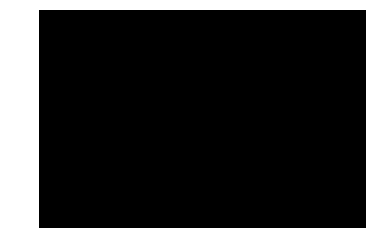

In [95]:
rh = RegistrationHelper(cent_h5_f)
H = rh.get_homography( warp_mode = cv2.MOTION_HOMOGRAPHY)
print(H)

affine = sitk.AffineTransform(3)
affine.SetMatrix(H.flatten())
print(affine)

show_projections(image_pair, affine)
